# Capstone Project Notebook

---

<details>
    <summary> This notebook will mainly be used for the completion of the IBM data science capstone project </summary>
    
---
    
</details>

---

In [1]:
import pandas as pd
import numpy as np

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


## Week 3

---

- Pull data in from Wiki
- Preprocess data by:
    - removing "Not assigned" boroughs
    - checking for "Not assigned" Neighbourhoods
- Display shape

In [3]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", header=0)[0]
df = df[df['Borough'] != 'Not assigned']
df = df.groupby(['Postal Code', 'Borough'], as_index=False)['Neighbourhood'].apply(lambda x: ", ".join(x))
df[df['Neighbourhood'] == 'Not assigned'] = df['Borough']
print("There are ", df.shape[0], " rows")

There are  103  rows


In [4]:
postal = pd.read_csv("http://cocl.us/Geospatial_data")
df = pd.merge(df, postal, on="Postal Code")
df

Postal Code      Borough  \
0           M1B  Scarborough   
1           M1C  Scarborough   
2           M1E  Scarborough   
3           M1G  Scarborough   
4           M1H  Scarborough   
..          ...          ...   
98          M9N         York   
99          M9P    Etobicoke   
100         M9R    Etobicoke   
101         M9V    Etobicoke   
102         M9W    Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
0                                       Malvern, Rouge  43.806686 -79.194353  
1               Rouge Hill, Port Union, Highland Creek  43.784535 -79.160497  
2                    Guildwood, Morningside, West Hill  43.763573 -79.188711  
3                                               Woburn  43.770992 -79.216917  
4                                            Cedarbrae  43.773136 -79.239476  
..                                                 ...        ...        ...  
98                                              Weston  43.706876 -79.518188  
99                                           Westmount  43.696319 -79.532242  
100  Kingsview Village, St. Phillips, Martin Grove ...  43.688905 -79.554724  
101  South Steeles, Silverstone, Humbergate, Jamest...  43.739416 -79.588437  
102                Northwest, West Humber - Clairville  43.706748 -79.594054  

[103 rows x 5 columns]

In [5]:
import folium

latitude = df['Latitude'][0]
longitude = df['Longitude'][0
                           ]
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Import Nearby Venue Data

- Prepare function
- Query Venues
- Map Venues (unique random colors per unique venue category)

In [6]:
import requests

CLIENT_ID = '2DAQ5Q4U0N10JXX1K5TLXV3SIGUCJGICC5PC1D0N5AZGCEUU' # your Foursquare ID
CLIENT_SECRET = 'DIVA5FHKFOXXHJ1XDONCSBMNTGHTPH2CP4WQUJYFJ3XJH4DC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
df_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
print(df_venues.shape)
df_venues.head()

(2118, 7)


Neighbourhood  Neighborhood Latitude  \
0                          Malvern, Rouge              43.806686   
1  Rouge Hill, Port Union, Highland Creek              43.784535   
2  Rouge Hill, Port Union, Highland Creek              43.784535   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                                              Venue  \
0              -79.194353                                            Wendy’s   
1              -79.160497                              Royal Canadian Legion   
2              -79.160497  SEBS Engineering Inc. (Sustainable Energy and ...   
3              -79.188711                                     RBC Royal Bank   
4              -79.188711                                  G & G Electronics   

   Venue Latitude  Venue Longitude              Venue Category  
0       43.807448       -79.199056        Fast Food Restaurant  
1       43.782533       -79.163085                         Bar  
2       43.782371       -79.156820  Construction & Landscaping  
3       43.766790       -79.191151                        Bank  
4       43.765309       -79.191537           Electronics Store

In [8]:
df_with_venues = pd.merge(df, df_venues, on='Neighbourhood').drop(['Latitude', 'Longitude'], axis=1)
print(len(df_with_venues['Neighbourhood'].unique()), " unique neighborhoods")
print(len(df_with_venues['Venue Category'].unique()), " unique venues")
df_with_venues

95  unique neighborhoods
268  unique venues


Postal Code      Borough  \
0            M1B  Scarborough   
1            M1C  Scarborough   
2            M1C  Scarborough   
3            M1E  Scarborough   
4            M1E  Scarborough   
...          ...          ...   
2183         M9V    Etobicoke   
2184         M9V    Etobicoke   
2185         M9W    Etobicoke   
2186         M9W    Etobicoke   
2187         M9W    Etobicoke   

                                          Neighbourhood  \
0                                        Malvern, Rouge   
1                Rouge Hill, Port Union, Highland Creek   
2                Rouge Hill, Port Union, Highland Creek   
3                     Guildwood, Morningside, West Hill   
4                     Guildwood, Morningside, West Hill   
...                                                 ...   
2183  South Steeles, Silverstone, Humbergate, Jamest...   
2184  South Steeles, Silverstone, Humbergate, Jamest...   
2185                Northwest, West Humber - Clairville   
2186                Northwest, West Humber - Clairville   
2187                Northwest, West Humber - Clairville   

      Neighborhood Latitude  Neighborhood Longitude  \
0                 43.806686              -79.194353   
1                 43.784535              -79.160497   
2                 43.784535              -79.160497   
3                 43.763573              -79.188711   
4                 43.763573              -79.188711   
...                     ...                     ...   
2183              43.739416              -79.588437   
2184              43.739416              -79.588437   
2185              43.706748              -79.594054   
2186              43.706748              -79.594054   
2187              43.706748              -79.594054   

                                                  Venue  Venue Latitude  \
0                                               Wendy’s       43.807448   
1                                 Royal Canadian Legion       43.782533   
2     SEBS Engineering Inc. (Sustainable Energy and ...       43.782371   
3                                        RBC Royal Bank       43.766790   
4                                     G & G Electronics       43.765309   
...                                                 ...             ...   
2183                                         McDonald's       43.741757   
2184                                         Pizza Nova       43.736761   
2185                                 Economy Rent A Car       43.708471   
2186                                      Saand Rexdale       43.705072   
2187                                          PC Garden       43.706539   

      Venue Longitude              Venue Category  
0          -79.199056        Fast Food Restaurant  
1          -79.163085                         Bar  
2          -79.156820  Construction & Landscaping  
3          -79.191151                        Bank  
4          -79.191537           Electronics Store  
...               ...                         ...  
2183       -79.584230        Fast Food Restaurant  
2184       -79.589817                 Pizza Place  
2185       -79.589943         Rental Car Location  
2186       -79.598725                   Drugstore  
2187       -79.599359               Garden Center  

[2188 rows x 9 columns]

In [12]:
import random

num_neighborhoods = len(df_with_venues['Neighbourhood'].unique())
num_venues = len(df_with_venues['Venue Category'].unique())

colors = []

for neighborhood in range((num_neighborhoods + num_venues)):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    colors = colors + [color]
    
colors_neighborhood = colors[:num_neighborhoods]
print(len(colors_neighborhood), " neighborhood colors")
colors_venues = colors[num_neighborhoods:len(colors)]
print(len(colors_venues), " venue colors")

95  neighborhood colors
268  venue colors


In [15]:
unique_venues = df_with_venues['Venue Category'].unique()
unique_neighborhoods = df_with_venues['Neighbourhood'].unique()

for lat, lng, venue, venue_category, borough, neighbourhood in \
zip(df_with_venues['Venue Latitude'], df_with_venues['Venue Longitude'], df_with_venues['Venue'], \
    df_with_venues['Venue Category'], \
    df_with_venues['Borough'], df_with_venues['Neighbourhood']):
    index_neighborhood = np.where(unique_neighborhoods == neighbourhood)[0][0]
    index_venue = np.where(unique_venues == venue_category)[0][0]
    label = 'Borough: {}, Neighborhood: {}, Category: {}, Venue: {}'.format(borough, neighbourhood, venue_category, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors_neighborhood[index_neighborhood],#'blue',
        fill=True,
        fill_color=colors_venues[index_venue],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
map_toronto

## Prepare Data For Clustering 

- One-hot Encoding
- Grouping with mean
- Finding most common venues for each neighborhood

In [22]:
# one hot encoding
one_hot_encoding = pd.get_dummies(df_with_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
one_hot_encoding['Neighborhood'] = df_with_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = list(one_hot_encoding.columns)
fixed_columns.remove("Neighborhood")
fixed_columns = ['Neighborhood'] + fixed_columns
one_hot_encoding = one_hot_encoding[fixed_columns]

one_hot_encoding.head()

Neighborhood  Accessories Store  Adult Boutique  \
0                          Malvern, Rouge                  0               0   
1  Rouge Hill, Port Union, Highland Creek                  0               0   
2  Rouge Hill, Port Union, Highland Creek                  0               0   
3       Guildwood, Morningside, West Hill                  0               0   
4       Guildwood, Morningside, West Hill                  0               0   

   Airport  Airport Food Court  Airport Lounge  Airport Service  \
0        0                   0               0                0   
1        0                   0               0                0   
2        0                   0               0                0   
3        0                   0               0                0   
4        0                   0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  ...  Train Station  \
0                 0                    0             0  ...              0   
1                 0                    0             0  ...              0   
2                 0                    0             0  ...              0   
3                 0                    0             0  ...              0   
4                 0                    0             0  ...              0   

   Turkish Restaurant  Vegetarian / Vegan Restaurant  Video Game Store  \
0                   0                              0                 0   
1                   0                              0                 0   
2                   0                              0                 0   
3                   0                              0                 0   
4                   0                              0                 0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0                      0                0         0            0   
1                      0                0         0            0   
2                      0                0         0            0   
3                      0                0         0            0   
4                      0                0         0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 268 columns]

In [23]:
grouped = one_hot_encoding.groupby('Neighborhood').mean().reset_index()
grouped

Neighborhood  Accessories Store  \
0                                         Agincourt                0.0   
1                            Alderwood, Long Branch                0.0   
2   Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                   Bayview Village                0.0   
4                 Bedford Park, Lawrence Manor East                0.0   
..                                              ...                ...   
90                      Willowdale, Willowdale East                0.0   
91                      Willowdale, Willowdale West                0.0   
92                                           Woburn                0.0   
93                                 Woodbine Heights                0.0   
94                                  York Mills West                0.0   

    Adult Boutique  Airport  Airport Food Court  Airport Lounge  \
0              0.0      0.0                 0.0             0.0   
1              0.0      0.0                 0.0             0.0   
2              0.0      0.0                 0.0             0.0   
3              0.0      0.0                 0.0             0.0   
4              0.0      0.0                 0.0             0.0   
..             ...      ...                 ...             ...   
90             0.0      0.0                 0.0             0.0   
91             0.0      0.0                 0.0             0.0   
92             0.0      0.0                 0.0             0.0   
93             0.0      0.0                 0.0             0.0   
94             0.0      0.0                 0.0             0.0   

    Airport Service  Airport Terminal  American Restaurant  Antique Shop  ...  \
0               0.0               0.0             0.000000           0.0  ...   
1               0.0               0.0             0.000000           0.0  ...   
2               0.0               0.0             0.000000           0.0  ...   
3               0.0               0.0             0.000000           0.0  ...   
4               0.0               0.0             0.043478           0.0  ...   
..              ...               ...                  ...           ...  ...   
90              0.0               0.0             0.000000           0.0  ...   
91              0.0               0.0             0.000000           0.0  ...   
92              0.0               0.0             0.000000           0.0  ...   
93              0.0               0.0             0.000000           0.0  ...   
94              0.0               0.0             0.000000           0.0  ...   

    Train Station  Turkish Restaurant  Vegetarian / Vegan Restaurant  \
0             0.0                 0.0                            0.0   
1             0.0                 0.0                            0.0   
2             0.0                 0.0                            0.0   
3             0.0                 0.0                            0.0   
4             0.0                 0.0                            0.0   
..            ...                 ...                            ...   
90            0.0                 0.0                            0.0   
91            0.0                 0.0                            0.0   
92            0.0                 0.0                            0.0   
93            0.0                 0.0                            0.0   
94            0.0                 0.0                            0.0   

    Video Game Store  Vietnamese Restaurant  Warehouse Store  Wine Bar  \
0                0.0               0.000000              0.0       0.0   
1                0.0               0.000000              0.0       0.0   
2                0.0               0.000000              0.0       0.0   
3                0.0               0.000000              0.0       0.0   
4                0.0               0.000000              0.0       0.0   
..               ...                    ...              ...   

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood      1st Most Common Venue  \
0                                        Agincourt  Latin American Restaurant   
1                           Alderwood, Long Branch                Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North                       Bank   
3                                  Bayview Village        Japanese Restaurant   
4                Bedford Park, Lawrence Manor East         Italian Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                Lounge        Breakfast Spot          Skating Rink   
1              Pharmacy                   Gym          Skating Rink   
2           Coffee Shop                 Diner         Shopping Mall   
3                  Café                  Bank    Chinese Restaurant   
4           Coffee Shop        Sandwich Place      Sushi Restaurant   

  5th Most Common Venue            6th Most Common Venue  \
0    Mexican Restaurant  Molecular Gastronomy Restaurant   
1           Coffee Shop               Athletics & Sports   
2                  Park        Middle Eastern Restaurant   
3         Movie Theater                            Motel   
4           Pizza Place          Comfort Food Restaurant   

        7th Most Common Venue 8th Most Common Venue  \
0  Modern European Restaurant     Mobile Phone Shop   
1                         Pub    Miscellaneous Shop   
2           Mobile Phone Shop        Sandwich Place   
3         Moroccan Restaurant   Monument / Landmark   
4                         Pub             Juice Bar   

             9th Most Common Venue           10th Most Common Venue  
0               Miscellaneous Shop        Middle Eastern Restaurant  
1              Monument / Landmark  Molecular Gastronomy Restaurant  
2                      Supermarket              Fried Chicken Joint  
3  Molecular Gastronomy Restaurant                Accessories Store  
4                       Restaurant                         Pharmacy

## Determine Number of Clusters and Apply K-Means

- Use Elbow Plot to find K
- Add cluster labels to dataset
- remap with cluster labels

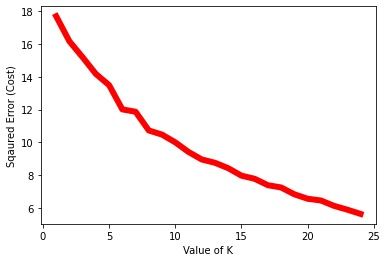

In [62]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

cost =[] 
for i in range(1, 25): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(grouped.iloc[:, 1:]) 
    cost.append(KM.inertia_)      

plt.plot(range(1, 25), cost, color ='r', linewidth ='6') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

In [63]:
kclusters = 5

grouped_clustering = grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

neighborhoods_venues_sorted['Cluster Labels'] = np.array(kmeans.labels_).astype(int)

merged = pd.merge(df, neighborhoods_venues_sorted)
merged

Postal Code      Borough  \
0          M1B  Scarborough   
1          M1C  Scarborough   
2          M1E  Scarborough   
3          M1G  Scarborough   
4          M1H  Scarborough   
..         ...          ...   
94         M9N         York   
95         M9P    Etobicoke   
96         M9R    Etobicoke   
97         M9V    Etobicoke   
98         M9W    Etobicoke   

                                        Neighbourhood   Latitude  Longitude  \
0                                      Malvern, Rouge  43.806686 -79.194353   
1              Rouge Hill, Port Union, Highland Creek  43.784535 -79.160497   
2                   Guildwood, Morningside, West Hill  43.763573 -79.188711   
3                                              Woburn  43.770992 -79.216917   
4                                           Cedarbrae  43.773136 -79.239476   
..                                                ...        ...        ...   
94                                             Weston  43.706876 -79.518188   
95                                          Westmount  43.696319 -79.532242   
96  Kingsview Village, St. Phillips, Martin Grove ...  43.688905 -79.554724   
97  South Steeles, Silverstone, Humbergate, Jamest...  43.739416 -79.588437   
98                Northwest, West Humber - Clairville  43.706748 -79.594054   

                                         Neighborhood 1st Most Common Venue  \
0                                      Malvern, Rouge  Fast Food Restaurant   
1              Rouge Hill, Port Union, Highland Creek                   Bar   
2                   Guildwood, Morningside, West Hill        Medical Center   
3                                              Woburn           Coffee Shop   
4                                           Cedarbrae           Gas Station   
..                                                ...                   ...   
94                                             Weston                  Park   
95                                          Westmount           Pizza Place   
96  Kingsview Village, St. Phillips, Martin Grove ...           Pizza Place   
97  South Steeles, Silverstone, Humbergate, Jamest...           Pizza Place   
98                Northwest, West Humber - Clairville         Garden Center   

         2nd Most Common Venue  3rd Most Common Venue  \
0                        Motel    Martial Arts School   
1   Construction & Landscaping      Accessories Store   
2          Rental Car Location                   Bank   
3                     Pharmacy  Korean BBQ Restaurant   
4          Fried Chicken Joint                 Bakery   
..                         ...                    ...   
94           Accessories Store     Mexican Restaurant   
95              Sandwich Place           Intersection   
96           Mobile Phone Shop               Bus Line   
97               Grocery Store    Fried Chicken Joint   
98         Rental Car Location              Drugstore   

        4th Most Common Venue            5th Most Common Venue  \
0              Massage Studio                   Medical Center   
1   Middle Eastern Restaurant              Monument / Landmark   
2              Breakfast Spot                     Intersection   
3   Middle Eastern Restaurant              Monument / Landmark   
4        Caribbean Restaurant                  Thai Restaurant   
..                        ...                              ...   
94        Monument / Landmark  Molecular Gastronomy Restaurant   
95             Discount Store        Middle Eastern Restaurant   
96             Sandwich Place         Mediterranean Restaurant   
97             Sandwich Place             Fast Food Restaurant   
98          Accessories Store               Miscellaneous Shop   

              6th Most Common Venue            7th Most Common Venue  \
0          Mediterranean Restaurant                      Men's Store   
1   Molecular Gastronomy Restaurant       Modern European Restaurant   
2                 Electronics Store   

In [64]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], \
                                  merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Observations

With K=5 it seems that there are good results as far as clusters being populated. It would be interesting to evaluated socioeconomics of these neighborhoods as well as population densities to improve the clustering.